# Probabilidade de Deteccao com os Datasets Baseados nas Features do Hassel e Kapetanovic

#### Introdução

Para cada combinação diferente de qtd de usuários, qtd de antenas, e qtd de símbolos na sequência piloto, gerou-se um dataset. As features são:

**snr:** variou de -10 dB até 30 dB com passo 2.5 dB;

**E:** energia definida no artigo do Hassel;

**eta:** parâmetro usado na comparação com E para dizer se há contaminação. No artigo ele definine que se E for maior que eta, há contaminação. Aqui a gnt vai deixar o classificador se preocupar com isso;

**a1:** maior autovalor da matriz R do Kapetanovic;

**a2:** segundo maior autovalor da matriz R do Kapetanovic;

**a3:** terceiro maior autovalor da matriz R do Kapetanovic. No algoritmo que ele definiu, a gnt usa a razão entre a1 e a2. Nos testes anteriores eu tinha deixado a1 e a2 soltos, sem fazer a razão, e funcionou bem. Vamos ver se colocando mais um autovalor da pra melhorar.

Ainda temos mais duas colunas de target, **potência do espião** e **contaminação presente**. A que realmente interessa pro classificador é essa última. Mas vamos usar a potência do espião pra separar os plots.

Quanto ao classificador, fiz alguns gridsearchs e parece que o SGD é o mais robusto, mas ainda é bom fazer mais testes. Nesse jupyter vamos usar o SGD, mas qqr coisa é só voltar aqui no futuro e trocar o classificador.

#### Objetivos

**1) Teste de features:** vamos ver se as features do kapetanovic realmente fazem diferença ou se a gnt pode só usar as do Hassel msm. Em seguida, vamos ver se o terceiro maior autovalor faz diferença ou se a gnt pode usar só até o segundo maior, como proposto no artigo.

**2) Probabilidade de detecção:** pra gnt conseguir enxergar os falsos positivos, vou plotar uma curva de probabilidade de detecção em função da snr para diferentes valores de potência do espião. Assim, se houver detecção quando a potência for 0, a gnt consegue avaliar os falsos positivos. Esse plot vai acontecer para cada dataset gerado, ou seja, para diferentes combinações de qtd de usuários, qtd de antenas, e qtd de símbolos na sequência piloto.

## Importações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [19]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [45, 3], 
    'axes.labelsize': 10,
    'axes.titlesize':12, 
    'font.size': 10,
    'legend.fontsize': 8, 
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

## Definição de funções

#### Função para abrir o dataset, filtrar os dados indesejados, e retornar os numpys

Essa função recebe o caminho pra um CSV e retorna os vetores de data e target. Como eu falei ali atrás, vamos separar os plots pela potência do espião, então também to retornando um vetor com a potência do espião. 

Sobre os filtros, como a gnt vai plotar em função da SNR tb, então quero já devolver somente os dados dessa snr, como se fosse um dataset pra cada SNR tb. E pelo primeiro objetivo, a gnt tb pode mandar um array com as colunas que a gnt quer dropar. Exemplo: droparFeatures=["a1", "a2", "a3"] vai retornar o dataset somente com E e eta.

In [3]:
def obterDados(caminhoCSV, snrDesejada=None, droparFeatures=None):
    
    # ABRO O CSV
    datasetCSV = pd.read_csv(caminhoCSV)
    
     # DROPANDO AS FEATURES DESEJADAS
    if droparFeatures != None:
        datasetCSV = datasetCSV.drop(droparFeatures, axis=1)
    
    # FILTRO PRA VOLTAR SOMENTE OS DADOS DE DETERMINADA SNR
    if snrDesejada != None:
        datasetCSV = datasetCSV.loc[(datasetCSV["snr"] == snrDesejada)]
        datasetCSV = datasetCSV.drop(["snr"], axis=1)

    # SEPARANDO DATA E OS DOIS TARGETS
    data                 = datasetCSV[datasetCSV.columns[:-2]].to_numpy()
    target               = datasetCSV[datasetCSV.columns[-1]].to_numpy()
    arrayPotenciasEspiao = datasetCSV[datasetCSV.columns[-2]].to_numpy()
    
    # RETORNO OS DADOS
    return data, target, arrayPotenciasEspiao

#### Train Test Split

Como eu vou precisar ter a informação de qual é a potência do espião em cada dado do dataset, vou fazer a função tts do zero. A implementação do scikit não me deixaria preservar a informação da potência do espião.

In [4]:
def holdout(data, target, arrayPotenciasEspiao, percentualTreinamento=0.75):
    
    # SHUFFLE NOS ARRAYS MANTENDO A COESAO ENTRE ELES
    data, arrayPotenciasEspiao, target = shuffle(data, arrayPotenciasEspiao, target)
    
    # INDEX ONDE VAI TERMINAR O TREINAMENTO E COMECAR O TESTE
    indexSeparador = int(percentualTreinamento * len(target))
    
    # SEPARANDO
    xTrain      = data[:indexSeparador]
    xTest       = data[indexSeparador:]
    yTrain      = target[:indexSeparador]
    yTest       = target[indexSeparador:]
    potEspTrain = arrayPotenciasEspiao[:indexSeparador]
    potEspTest  = arrayPotenciasEspiao[indexSeparador:]
    
    return xTrain, xTest, yTrain, yTest, potEspTrain, potEspTest

#### Função para treinar, testar e retornar yTest, yPred, potEspTest

Vamos enviar os dados data,target e arrayPotenciasEspiao. A função vai separar os dados usando a função criada acima e vai retornar yTest e yPred pra que seja possível calcular qualquer métrica. Ela também vai retornar potEspTest pra que seja possível calcular as métricas para cada potência de espião. Ela não tem validação cruzada, é só um holdoutzinho.

In [5]:
def holdoutComClassificacao(data, target, arrayPotenciasEspiao, classificador, percentualTreinamento=0.75):

    # SEPARANDO OS DADOS ALEATORIAMENTE
    xTrain, xTest, yTrain, yTest, potEspTrain, potEspTest = holdout(data, target, arrayPotenciasEspiao, percentualTreinamento)

    # TREINANDO O CLASSIFICADOR
    objClassificador = eval(classificador)
    objClassificador.fit(xTrain, yTrain)

    # PREDIZENDO OS DE TESTE
    yPred = objClassificador.predict(xTest)
        
    return yTest, yPred, potEspTest

#### Função para somar matrizes de confusão

Essa a gnt vai usar só pra cumprir o objetivo 1, no segundo já vai ser por outro método. A ideia aqui é só fazer vários holdouts pra compor um bootstrap. A cada iteração a gnt vai somando uma matriz de confusão em cima da outra e retorna essa soma.

In [6]:
def somarMatrizesConfusao(data, target, arrayPotenciasEspiao, classificador, percentualTreinamento=0.75, qtdHoldouts=100):
    
    # SOMAR A MATRIZ DE CONFUSAO DE CADA ITERACAO
    matrizesConfusaoSomadas = np.array([[0,0],[0,0]])
    
    # PARA CADA HOLDOUT
    for i in range(qtdHoldouts):
        
        # HOLDOUT E CLASSIFICACAO, SEM PREOCUPACAO COM AS POTENCIAS DO ESPIAO
        yTest, yPred, __ = holdoutComClassificacao(data, target, arrayPotenciasEspiao, classificador, percentualTreinamento)
        
        # MATRIZ DE CONFUSAO
        matrizesConfusaoSomadas += confusion_matrix(yTest, yPred)
        
    return matrizesConfusaoSomadas

#### Função pra printar as matrizes somadas 

In [7]:
def printarSomaMatrizesConfusao(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios):
    
    plt.rcParams.update({'figure.figsize': [12.5, 2.5]})
    fig, axs = plt.subplots(1, len(rangeQtdUsuarios))
    
    for k, (matrizAtual, qtdUsuariosAtual) in enumerate(zip(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios)):
    
        acuracia = (matrizAtual[0][0]+matrizAtual[1][1])/np.sum(matrizAtual)

        axs[k].set_title("Usuarios: "+str(qtdUsuariosAtual)+" - Acc: "+str(acuracia)[:7])
        axs[k].imshow(matrizAtual, cmap="gray")

        for (j,i), total in np.ndenumerate(matrizAtual):
            axs[k].text(i, j, total, ha="center", va="center", color="tab:red")

        axs[k].set_xlabel("Predito")
        axs[k].set_ylabel("Real")
    
    plt.show()

#### Função para calcular a probabilidade do classificador detectar um ataque em cada valor de potência de espião

Agora, para o segundo objetivo: para um único holdout, a gnt manda os valores preditos e quais foi a potência do espião em cada um desses dados. Ai é só calcular a acurácia pra cada potência diferente.

In [8]:
def calcularProbabilidadeDeteccaoCadaPotenciaEspiao(yPred, potEspTest):
    # CRIANDO OS ARRAYS QUE VAO GUARDAR AS OCORRENCIAS DE PREDICOES POSITIVAS E TAL
    arrayUniquePotEsp       = np.unique(potEspTest) # array que guarda os valores possiveis de pot de espiao
    arrayContagemCadaPotEsp = np.zeros(len(np.unique(potEspTest))) # contando quantos dados sao de cada pot do espiao
    arrayDeteccaoCadaPotEsp = np.zeros(len(np.unique(potEspTest))) # contando quantos desses dados de cada pot foram classificados como 1

    # PARA CADA DADO, VOU VERIFICAR A PREDICAO QUE ELE RECEBEU E A POTENCIA DO ESPIAO
    for (predicaoAtual, potEspAtual) in zip(yPred, potEspTest):

        # INDEX PRA SABER DE QUAL POSICAO DOS ARRAYS EU TO FALANDO
        indexPotEspAtual = np.where(arrayUniquePotEsp==potEspAtual)[0][0]

        # AUMENTO A CONTAGEM DA POTENCIA ATUAL
        arrayContagemCadaPotEsp[indexPotEspAtual] += 1

        # SE A PREDICAO FOI POSITIVA, EU SOMO UM NAS PREDICOES POSITIVAS DESSA POTENCIA
        arrayDeteccaoCadaPotEsp[indexPotEspAtual] += predicaoAtual

    # RETORNANDO O PERCENTUAL DE DETECCOES EM CADA POTENCIA DE ESPIAO
    return arrayDeteccaoCadaPotEsp/arrayContagemCadaPotEsp

#### Função para rodar o objetivo 2

In [9]:
def avaliarObjetivo2(qtdAntenas, qtdSimbolos, rangeQtdUsuarios, rangeSNRs, droparFeatures, classificador):

    fig, axs = plt.subplots(1, len(rangeQtdUsuarios))

    for l, qtdUsuarios in enumerate(rangeQtdUsuarios):

        caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos.csv"
        matrizProbabilidadesDeteccao = []

        for snrAtual in rangeSNRs:
            data, target, arrayPotenciasEspiao = obterDados(caminhoCSV, snrAtual, droparFeatures)
            __, yPred, potEspTest = holdoutComClassificacao(data, target, arrayPotenciasEspiao, classificador)
            probabilidadeDeteccaoCadaPotEsp = calcularProbabilidadeDeteccaoCadaPotenciaEspiao(yPred, potEspTest)
            matrizProbabilidadesDeteccao.append(probabilidadeDeteccaoCadaPotEsp)

        matrizProbabilidadesDeteccao = np.transpose(matrizProbabilidadesDeteccao)

        for (potEspAtual, probabilidadeDeteccaoCadaSNR) in zip(np.unique(potEspTest), matrizProbabilidadesDeteccao):
            axs[l].plot(rangeSNRs, probabilidadeDeteccaoCadaSNR, label="Potência do Espião: "+str(potEspAtual))

        axs[l].set_title("Usuários: "+str(qtdUsuarios))
        axs[l].set_xlabel("SNR")
        axs[l].set_ylabel("Probabilidade de Detecção")
        axs[l].grid(alpha=0.5)
        axs[l].legend()

    plt.show()

## 1) Teste de features: 

Vamos ver se as features do kapetanovic realmente fazem diferença ou se a gnt pode só usar as do Hassel msm. Em seguida, vamos ver se o terceiro maior autovalor faz diferença ou se a gnt pode usar só até o segundo maior, como proposto no artigo. Aqui eu vou jogar todas as SNRs, portanto, a SNR é uma feature tb.

In [13]:
classificador    = "RandomForestClassifier(n_estimators=10, n_jobs=-1)" # "SGDClassifier(loss='modified_huber', tol=0.0001)"
qtdHoldouts      = 50
snrDesejada      = None
qtdAntenas       = 256
qtdSimbolos      = 128
rangeQtdUsuarios = np.array([1, 2, 4])

### Somente a1 e a2

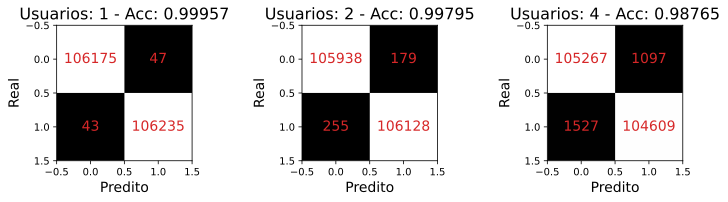

In [9]:
droparFeatures = ["E", "eta", "a3"]

matrizesConfusaoCadaQtdUsuarios = []

for qtdUsuarios in rangeQtdUsuarios:
    caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos.csv"
    data, target, arrayPotenciasEspiao = obterDados(caminhoCSV, snrDesejada, droparFeatures)
    matrizesConfusaoSomadas = somarMatrizesConfusao(data, target, arrayPotenciasEspiao, classificador, qtdHoldouts=qtdHoldouts)
    matrizesConfusaoCadaQtdUsuarios.append(matrizesConfusaoSomadas)
    
printarSomaMatrizesConfusao(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios)

### Somente a1, a2 e a3

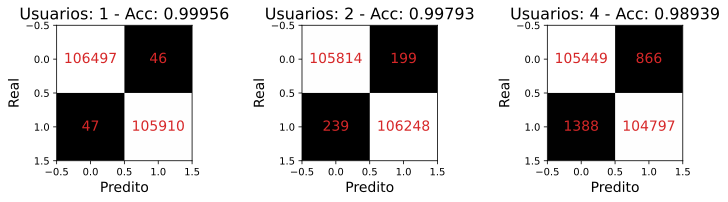

In [10]:
droparFeatures = ["E", "eta"]

matrizesConfusaoCadaQtdUsuarios = []

for qtdUsuarios in rangeQtdUsuarios:
    caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos.csv"
    data, target, arrayPotenciasEspiao = obterDados(caminhoCSV, snrDesejada, droparFeatures)
    matrizesConfusaoSomadas = somarMatrizesConfusao(data, target, arrayPotenciasEspiao, classificador, qtdHoldouts=qtdHoldouts)
    matrizesConfusaoCadaQtdUsuarios.append(matrizesConfusaoSomadas)
    
printarSomaMatrizesConfusao(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios)

### Somente E e eta

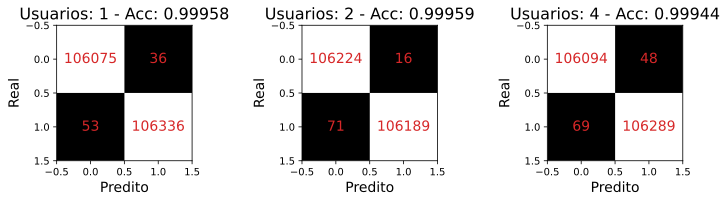

In [11]:
droparFeatures = ["a1", "a2", "a3"]

matrizesConfusaoCadaQtdUsuarios = []

for qtdUsuarios in rangeQtdUsuarios:
    caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos.csv"
    data, target, arrayPotenciasEspiao = obterDados(caminhoCSV, snrDesejada, droparFeatures)
    matrizesConfusaoSomadas = somarMatrizesConfusao(data, target, arrayPotenciasEspiao, classificador, qtdHoldouts=qtdHoldouts)
    matrizesConfusaoCadaQtdUsuarios.append(matrizesConfusaoSomadas)
    
printarSomaMatrizesConfusao(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios)

### Somente E, eta, a1 e a2

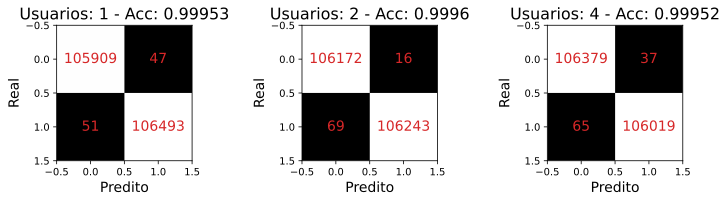

In [12]:
droparFeatures = ["a3"]

matrizesConfusaoCadaQtdUsuarios = []

for qtdUsuarios in rangeQtdUsuarios:
    caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos.csv"
    data, target, arrayPotenciasEspiao = obterDados(caminhoCSV, snrDesejada, droparFeatures)
    matrizesConfusaoSomadas = somarMatrizesConfusao(data, target, arrayPotenciasEspiao, classificador, qtdHoldouts=qtdHoldouts)
    matrizesConfusaoCadaQtdUsuarios.append(matrizesConfusaoSomadas)
    
printarSomaMatrizesConfusao(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios)

### Todas 

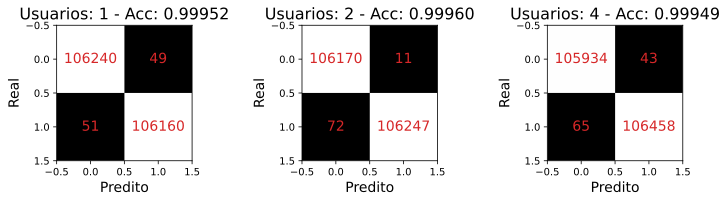

In [13]:
droparFeatures = None

matrizesConfusaoCadaQtdUsuarios = []

for qtdUsuarios in rangeQtdUsuarios:
    caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos.csv"
    data, target, arrayPotenciasEspiao = obterDados(caminhoCSV, snrDesejada, droparFeatures)
    matrizesConfusaoSomadas = somarMatrizesConfusao(data, target, arrayPotenciasEspiao, classificador, qtdHoldouts=qtdHoldouts)
    matrizesConfusaoCadaQtdUsuarios.append(matrizesConfusaoSomadas)
    
printarSomaMatrizesConfusao(matrizesConfusaoCadaQtdUsuarios, rangeQtdUsuarios)

## 2) Probabilidade de detecção: 

Pra gnt conseguir enxergar os falsos positivos, vou plotar uma curva de probabilidade de detecção em função da snr para diferentes valores de potência do espião. Assim, se houver detecção quando a potência for 0, a gnt consegue avaliar os falsos positivos. Esse plot vai acontecer para cada dataset gerado, ou seja, para diferentes combinações de qtd de usuários, qtd de antenas, e qtd de símbolos na sequência piloto.

### Parâmetros Fixos

In [17]:
droparFeatures   = None
rangeSNRs        = np.arange(-10, 31, 1)
rangeQtdUsuarios = np.array([1, 2, 4, 8, 16, 32, 64])

### 256 antenas e 128 símbolos

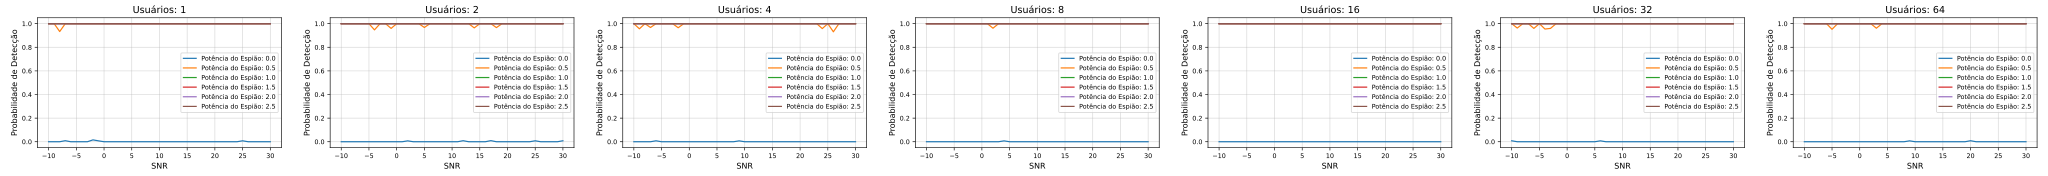

In [20]:
qtdAntenas  = 256
qtdSimbolos = 128
avaliarObjetivo2(qtdAntenas, qtdSimbolos, rangeQtdUsuarios, rangeSNRs, droparFeatures, classificador)

### 256 antenas e 8 símbolos

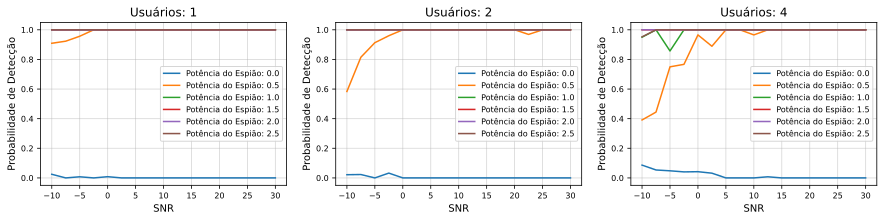

In [103]:
qtdAntenas  = 256
qtdSimbolos = 8
avaliarObjetivo2(qtdAntenas, qtdSimbolos, rangeQtdUsuarios, rangeSNRs, droparFeatures, classificador)

### 64 antenas e 128 símbolos

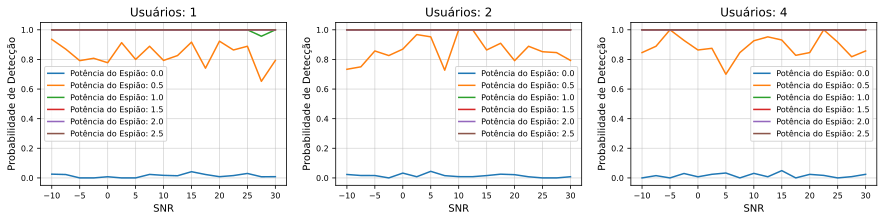

In [104]:
qtdAntenas  = 64
qtdSimbolos = 128
avaliarObjetivo2(qtdAntenas, qtdSimbolos, rangeQtdUsuarios, rangeSNRs, droparFeatures, classificador)

###  64 antenas e 8 símbolos

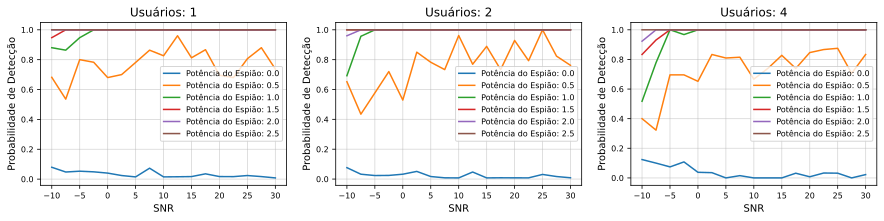

In [105]:
qtdAntenas  = 64
qtdSimbolos = 8
avaliarObjetivo2(qtdAntenas, qtdSimbolos, rangeQtdUsuarios, rangeSNRs, droparFeatures, classificador)